In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

import numpy as np

from querymsc import WorkflowTools
%load_ext autoreload
%autoreload 2

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
start_time = datetime.datetime(1950, 1, 1)
end_time = datetime.datetime(2019, 1, 1)

msc = WorkflowTools(start_time, end_time)

69.0


In [4]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)
query_temp = msc.query_design_temp_percentile(session)

In [5]:
query = msc.query_design_temp_percentile(session)

In [6]:
annual_tot_precip = msc.query_annual_precip(session)
#pd.read_sql(annual_tot_precip.statement, engine).head()

In [7]:
annual_tot_rain = msc.query_annual_rain(session)
#pd.read_sql(annual_tot_rain.statement, engine).head()

In [8]:
query_temp = msc.query_design_temp_percentile(session)
#pd.read_sql(query_temp.statement, engine)

In [9]:
query_design_temp_dry = msc.query_design_temp_dry(session)
#pd.read_sql(query_design_temp_dry.statement, engine).head()

In [10]:
query_design_temp_wet = msc.query_design_temp_wet(session)
#pd.read_sql(query_design_temp_wet.statement, engine)

In [11]:
hdd = msc.query_deg_day_below_18(session)
#pd.read_sql(hdd.statement, engine)

In [12]:
df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
#df_vars[df_vars['net_var_name']=='127']
#df_vars[(df_vars['net_var_name'].astype(int) > 124) & (df_vars['net_var_name'].astype(int) < 132)]
df_test = df_vars[df_vars['standard_name'].str.contains('precip')]
df_test

,vars_id,standard_name,long_description,unit,cell_method,net_var_name
72,1361,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-60),0.1 mm,time: sum,262
73,1362,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-15),0.1 mm,time: sum,263
74,1363,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 15-30),0.1 mm,time: sum,264
75,1364,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 30-45),0.1 mm,time: sum,265
76,1365,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 45-60),0.1 mm,time: sum,266
108,1397,lwe_thickness_of_precipitation_amount,Total precipitation,0.1 mm,time: sum,12
119,1412,lwe_thickness_of_precipitation_amount,1200 UTC,0.1 mm,time: sum,6
120,1413,lwe_thickness_of_precipitation_amount,1800 UTC,0.1 mm,time: sum,7
121,1414,lwe_thickness_of_precipitation_amount,0000 UTC,0.1 mm,time: sum,8
122,1415,lwe_thickness_of_precipitation_amount,0600 UTC,0.1 mm,time: sum,9


In [13]:
one_day_query = msc.query_rain_rate_one_day_1_50(session)
df_one_day = pd.read_sql(one_day_query.statement, engine)

In [14]:
df_one_day

,rainfall_rate,elev,time_min,time_max,lat,lon,station_id,completeness
0,46.2,112.50,1950-01-01,1950-12-31,43.6667,-79.4000,6538,0.985636
1,49.6,112.50,1951-01-01,1951-12-31,43.6667,-79.4000,6538,0.963733
2,43.0,112.50,1952-01-01,1952-12-31,43.6667,-79.4000,6538,0.993850
3,43.2,112.50,1953-01-01,1953-12-31,43.6667,-79.4000,6538,0.985636
4,97.2,112.50,1954-01-01,1954-12-31,43.6667,-79.4000,6538,0.974685
5,63.9,112.50,1955-01-01,1955-11-30,43.6667,-79.4000,6538,0.906238
6,41.5,44.00,1956-01-01,1956-12-09,44.6333,-63.5000,8278,0.914451
7,29.5,112.50,1958-01-02,1958-07-31,43.6667,-79.4000,6538,0.561265
8,44.4,7.60,1960-01-01,1960-12-28,48.0000,-66.6667,7841,0.928141
9,58.5,15.00,1960-01-01,1960-12-31,49.2431,-121.7600,802,0.999325


In [ ]:
rain_rate = msc.query_rain_rate_15(session)
df_rain_rate = pd.read_sql(rain_rate.statement, engine)

In [254]:
rain_rate_test = msc.query_rain_rate_15_rfr_test(session)
df_rain_rate_test = pd.read_sql(rain_rate_test.statement, engine)

69.0


In [218]:
df_rain_rate.sort_values(by='station_id')

,rainfall_rate,time_min,time_max,lat,lon,station_id,completeness
528,32.4,2010-01-01 08:00:00,2010-12-31 23:00:00,48.8242,-123.7190,73,0.728019
1373,3.9,2013-01-01 00:00:00,2013-12-31 23:00:00,48.8242,-123.7190,73,0.998869
332,5.8,2009-01-01 00:00:00,2009-12-31 23:00:00,48.8242,-123.7190,73,0.993564
2875,7.2,2017-01-01 08:00:00,2017-12-20 01:00:00,48.8242,-123.7190,73,0.965615
2475,5.6,2016-01-01 00:00:00,2016-12-31 23:00:00,48.8242,-123.7190,73,0.997301
1725,6.1,2014-01-01 08:00:00,2014-12-31 22:00:00,48.8242,-123.7190,73,0.961195
120,2.8,2007-11-27 16:00:00,2007-12-31 23:00:00,48.8242,-123.7190,73,0.088354
1051,3.6,2012-01-01 00:00:00,2012-12-31 23:00:00,48.8242,-123.7190,73,0.949245
783,3.4,2011-01-01 00:00:00,2011-12-31 23:00:00,48.8242,-123.7190,73,0.810783
2092,4.0,2015-01-01 01:00:00,2015-12-31 23:00:00,48.8242,-123.7190,73,0.993850


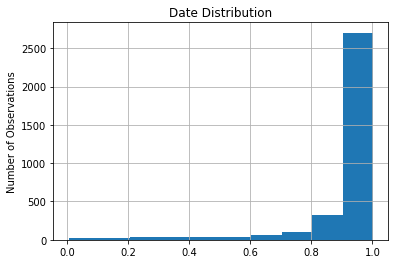

In [15]:
df_one_day['completeness'].hist()
#df_rain_rate['time_min'].hist()
plt.ylabel('Number of Observations')
plt.title('Date Distribution')
plt.savefig('./plots/date_dist.pdf')

In [40]:
df_rain_one = df_one_day[df_one_day['completeness'] > 0.15] 
#df_rain = df_rain_rate#[(df_rain_rate['completeness'] > 0.85) & (df_rain_rate['rainfall_rate'] > 0) ]
#df_rain_test = df_rain_rate_test[(df_rain_rate_test['completeness'] > 0.5) & (df_rain_rate_test['rainfall_rate'] > 0) ]

In [41]:
df_rain_one['station_id'].unique().shape

(528,)

In [42]:
iv = 0.1

from scipy import interpolate
import lmoments3 as lm
from lmoments3 import distr
from scipy.stats import gumbel_r
#paras = distr.gam.lmom_fit(x)

def fit_gumbel(x):
    #x = x['rainfall_rate'].values
    N = x.shape[0]
    euler = 0.5772156649
    if N >= 10:
        paras = distr.gum.lmom_fit(x)
        #fitted_gum = distr.gum(**paras)
        #exval = fitted_gum.ppf(0.1)
        K_T = -(np.sqrt(6.)/np.pi)*(euler+np.log(np.log(10/9.))) 
        S = np.std(x)
        Y_bar = np.mean(x)+K_T*S
        
        lmoments = distr.gum.lmom(nmom=2, **paras)
        #lmoments = lm.lmom(x, nmom=2)
        alpha = lmoments[1]/np.log(2)
        xi = lmoments[0] - euler*alpha 
        ok = get_gumbel_design_value(xi, alpha)
        
        fitted_gum = distr.gum(**paras)
        #val = fitted_gum.ppf(0.9)
        return ok
    else:
        return np.nan
    
def get_gumbel_design_value(xi, alpha):
    gamma = (1-0.1) + np.exp(-np.exp((xi/alpha)))
    est = xi - alpha*np.log(-np.log(gamma))
    return est

def type_i_gumbel(x, mu, beta):
    A = (1./beta)*np.exp(-(x-mu)/beta)
    B = np.exp(-np.exp(-(x-mu)/beta))
    return A*B

def type_i_gumbel_cdf(x, mu, beta):
    B = np.exp(-np.exp(-(x-mu)))
    return B


dv = []
#df_rain_before = df_rain.groupby('station_id')['rainfall_rate'].apply(fit_gumbel)
df_rain_new = df_rain_one.join(df_rain_one.groupby('station_id')['rainfall_rate'].apply(fit_gumbel), on='station_id', rsuffix='_new')

#for name, group in df_gb:
#    if group.values.shape[0] >= 10:
#        # print the data of that regiment
#        #print('group', group.values)
#        #print(group['rainfall_rate'])
#        df_grouped.groupby(level=[0, 1, 2]).apply(fancy_func)
#    df_gb.['new'] = fit_gumbel(group['rainfall_rate'].values)
#

station_list = df_rain_new.dropna()['station_id'].dropna().unique()
station_list.shape

(106,)

In [43]:
#df_rain_new = df_rain_new[df_rain_new['rainfall_rate_new'] <= 250]
df_rain_new.dropna().sort_values(by='station_id')

,rainfall_rate,elev,time_min,time_max,lat,lon,station_id,completeness,rainfall_rate_new
2514,60.4,45.7,1984-01-01,1984-12-31,48.8242,-123.7180,72,0.999325,83.811436
2821,82.6,45.7,1986-01-01,1986-12-31,48.8242,-123.7180,72,0.999325,83.811436
1419,30.8,45.7,1976-01-01,1976-04-08,48.8242,-123.7180,72,0.257361,83.811436
3134,60.2,45.7,1988-01-01,1988-12-31,48.8242,-123.7180,72,0.971947,83.811436
2974,63.8,45.7,1987-01-01,1987-12-31,48.8242,-123.7180,72,0.980160,83.811436
3330,77.5,45.7,1990-01-01,1990-12-31,48.8242,-123.7180,72,0.988374,83.811436
1174,45.0,45.7,1974-01-01,1974-12-02,48.8242,-123.7180,72,0.892548,83.811436
2348,75.0,45.7,1983-01-01,1983-12-13,48.8242,-123.7180,72,0.947306,83.811436
2674,47.4,45.7,1985-01-01,1985-12-31,48.8242,-123.7180,72,0.996588,83.811436
3268,32.6,45.7,1989-01-01,1989-12-31,48.8242,-123.7180,72,0.980160,83.811436


In [44]:
#alpha, xi, S, Y_bar = zip(*df_rain_new['rainfall_rate_new'].dropna().values)

In [45]:
#plt.scatter(alpha, S, marker = 'x')
#plt.xlim(0, 10)
#plt.ylim(0, 10)
#plt.title('Second Moment')
#plt.xlabel('L-moments')
#plt.ylabel('MoM')
#plt.savefig('./plots/second_moment.pdf')

In [46]:
#plt.scatter(xi, Y_bar, marker = 'x')
#plt.xlim(0, 30)
#plt.ylim(0, 30)
#plt.title('First Moment')
#plt.xlabel('L-moments')
#plt.ylabel('MoM')
#plt.savefig('./plots/first_moment.pdf')

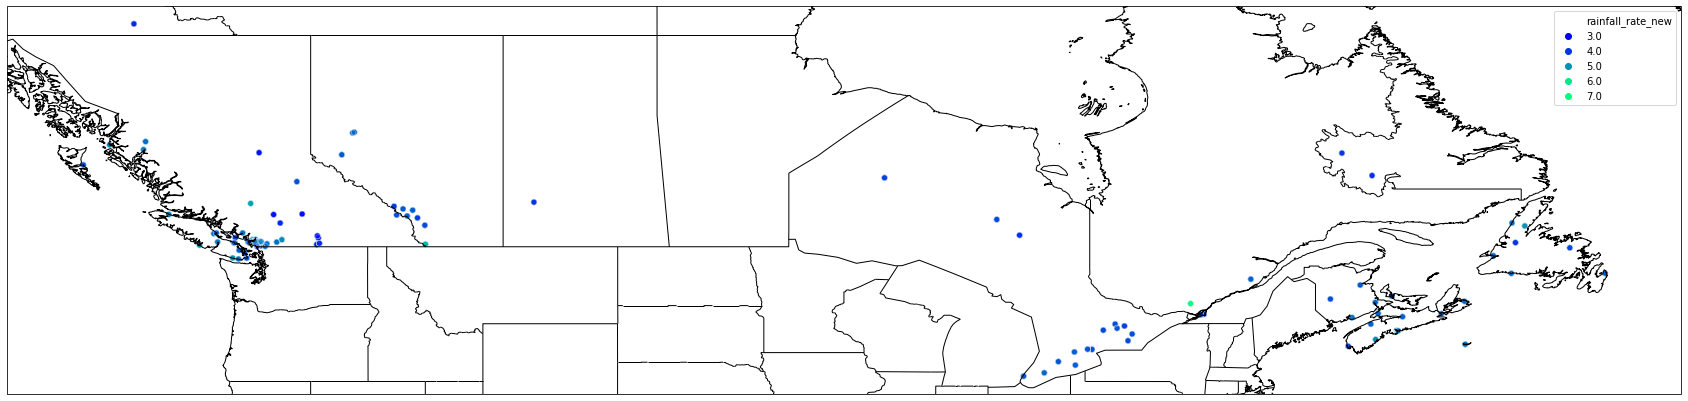

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_rain_new['lon'], df_rain_new['lat'], hue=np.log(df_rain_new['rainfall_rate_new']), palette="winter", alpha=.3)
#plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/canada_15_min_rain.pdf')

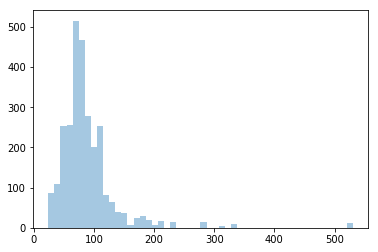

In [24]:
sns.distplot(df_rain_new['rainfall_rate_new'].dropna().values, kde=False)

In [25]:
#df_rain_rate['obs_count'].value_counts().idxmax()

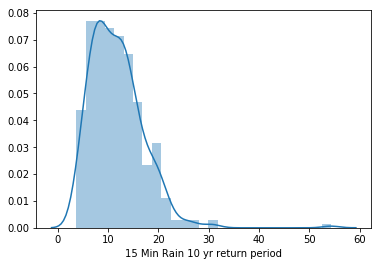

In [373]:
sns.distplot(df_dv[df_dv['dv'] < 60]['dv'])#.hist(bins = 100)
plt.xlabel('15 Min Rain 10 yr return period')
plt.savefig('./plots/15_min_rain.pdf')

In [48]:
import numpy as np
from sklearn.cluster import OPTICS
from sklearn import preprocessing

X = df_rain_one[['rainfall_rate', 'elev', 'lat', 'lon', 'completeness']].values
scaler = preprocessing.StandardScaler().fit_transform(X)
X_embedded = OPTICS.reachability_
X_embedded.shape

ImportError: cannot import name 'OPTICS'

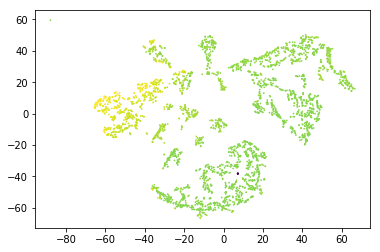

In [30]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_rain_new['elev'], s=0.5)

In [416]:
import sklearn.model_selection
import sklearn.datasets

import autosklearn.regression

X = df_rain_rate[['lat', 'lon', 'completeness']].values
y = df_rain_rate[['rainfall_rate']].values

def main():
    X, y = sklearn.datasets.load_boston(return_X_y=True)
    feature_types = (['numerical'] * 3) + ['categorical'] + (['numerical'] * 9)
    X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)

    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
        tmp_folder='./tmp/autosklearn_regression_example_tmp',
        output_folder='./tmp/autosklearn_regression_example_out',
    )
    automl.fit(X_train, y_train, dataset_name='boston',
               feat_type=feature_types)

    print(automl.show_models())
    predictions = automl.predict(X_test)

if __name__ == '__main__':
    main()

AttributeError: module 'sklearn' has no attribute 'metrics'